In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_ODT_sequence_new.jl")
;

In [3]:
function survived(t_end, times, trajectories)
    _survived = Int64[]
    for i ∈ eachindex(trajectories)
        if abs(times[i][end] - t_end*1e3) <= 1.0
            push!(_survived, i)
        end
    end
    return _survived
end

function cloud_size(trajectories, i)
    std(trajectory[i] for trajectory ∈ trajectories)
end

"""
    Evaluates the density given a set of trajectories.
"""
function density(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    println(_survived)
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = length(_survived)
    _density = Float64(n)
    if n > 1
        idx_end = length(surviving_x_trajectories[1])
        σ_x = cloud_size(surviving_x_trajectories, idx_end)
        σ_y = cloud_size(surviving_y_trajectories, idx_end)
        σ_z = cloud_size(surviving_z_trajectories, idx_end)
        _density /= σ_x * σ_y * σ_z
    end
    return _density
end

function distance(x_trajectory, y_trajectory, z_trajectory, idx)
    return sqrt(x_trajectory[idx]^2 + y_trajectory[idx]^2 + z_trajectory[idx]^2)
end

"""
    Evaluates how many particles are within a 0.3 mm radius.
"""
function goodness(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    @printf("Survival: %i / %i", length(_survived), n_molecules)
    println()
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(x_trajectories[survived_idx])
        r = distance(x_trajectories[survived_idx], y_trajectories[survived_idx], z_trajectories[survived_idx], idx_end)
        if r > 1.0
            n += 0.0
        elseif r > 0.5
            n += 0.1 * exp(-results.photons_scattered[survived_idx]/14000)
        elseif r > 0.3
            n += (0.6 - r)* exp(-results.photons_scattered[survived_idx]/14000)
        elseif r <= 0.3
            n += ((0.3 - r) * 3 + 0.3) * exp(-results.photons_scattered[survived_idx]/14000)
        end
    end
    return n/n_molecules
end
;

### Set up the molecule

In [4]:
package = get_CaOH_package();
package_A = get_CaOH_package_12_A_states();
n_states = length(package.states)
n_excited = package.n_excited;

In [5]:
function get_Δ_from_exp(voltage, aom_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 57 - 7.4*(5.5-voltage)
    Δ2 = Δ1 + 51.24 - aom_freq
    return Δ1, Δ2
end

function get_ODT_Hamiltonian_matrix(package, package_A, peak_intensity, pol, wavelength=1064e-9)
    Is = π*h*c*Γ/(3λ^3) / 10 # saturation intensity in mW/cm^2
    s = peak_intensity / Is
    f_ODT = c/wavelength 
    
    n_states = length(package.states)
    E0 = sqrt(s)/(2 * √2) # factor?
    H_ODT = zeros(ComplexF64, n_states, n_states)
    
    d = package_A.d
    fs = energy.(package_A.states)

    
    for q in 1:3
        for p in 1:3
            
            for i in 1:n_states
                for j in 1:n_states
                    for l in 1:length(package_A.states)
                    H_ODT[i,j] -= 2π * Γ * (E0^2/4 * d[min(i,l),max(i,l),q] * pol[q] * d[min(j,l),max(j,l),p] * pol[p]) * 
                                    (1/(fs[l]-fs[i] - f_ODT) + 1/(fs[l]-fs[i] + f_ODT))
                    end
                end
            end
            
        end
    end
    
    return H_ODT
end

function particles_in_ODT(results)
    indicies = []
    number = 0.0
   for i in 1:length(results.x_trajectories)
        if abs(results.x_trajectories[i][end]) < 0.05 && abs(results.z_trajectories[i][end]) < 0.05 
            push!(indicies, i)
            number += exp(-results.photons_scattered[i]/14000)
        end 
    end
    return number, indicies
end

function generate_sequence!(sequence, timing)
    t_last = 0.0
    i_last = 1
   for params in sequence
        params.t_start = t_last
        params.t_end = t_last + timing[i_last]
        t_last = t_last + timing[i_last]
        i_last += 1
    end
end



"""
    Function to optimize (density).
"""
function f(x)
    s1 = x[1]
    s3 = x[2]

    Δ1 = x[3]*Γ
    Δ3 = x[4]*Γ
    

    ramp_time = x[5]*1e-3 
    B_gradient = x[6]
    
    temp = @with_unit 0.050 "mK"
    diameter = @with_unit 0.8 "mm"
    displacement = [0.5, 0.5, 0.5]*1e-3
    kick = [0,0, 0.0, 0.0]


    s4 = 0.0
    Δ4 = 0.0
    s2 = 0.0
    Δ2 = 0.0



    blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 15e-3, n_values = 20,
                                pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁺, 
                                s1=s1, s2=s2, s3=s3, s4=s4,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = 30e-3,
                                s_ramp_to_factor = 1,

                                photon_budget=Inf, dark_lifetime=1/(1e6), FC_mainline=0.95,
                                pol_imbalance=0.00, 
                                s_imbalance = (0.0, 0.0, -0.00), retro_loss=0.00, 

                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0,0,0,0],

                                ODT_intensity = 13.3*1e3/(50e-4)^2*0,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3)


    sequence = [blue_MOT_params]
    durations = [ramp_time + 5e-3]
    generate_sequence!(sequence, durations)



    @time results = simulate_particles_ODT(package, package_A, sequence, variable_budget=true);
    
    @printf("s1 = %.2f; s3 = %.2f; Δ1 = %.2fΓ; Δ3 = %.2fΓ; B_gradient = %.2f; ramp_time = %.2e",x[1], x[2], x[3], x[4], x[5],x[6]*1e-3)
    println()
    
    _goodness = goodness(blue_MOT_params.t_end, results) * 100

    
    @printf("goodness = %.3f", _goodness)
    println()
    
    return _goodness
end
;    

In [6]:
using BayesianOptimization, GaussianProcesses

model = ElasticGPE(6,                            # 6 input dimensions
                   mean = MeanConst(1.),         
                   kernel = SEArd([0.1, 0.1, 0.1, 0.1,0.1,0.1], 5.),
                   logNoise = 0.,
                   capacity = 3000)              # the initial capacity of the GP is 3000 samples
set_priors!(model.mean, [Normal(1, 1)])

# Optimize the hyperparameters of the GP using maximum a posteriori (MAP) estimates every x steps
modeloptimizer = MAPGPOptimizer(
    every = 1, 
    noisebounds = [-3, 3], # bounds of the logNoise
    kernbounds = [[-3, -3, -3, -3,-3,-3, -5], [3, 3, 3, 3,3,3,5]],  # bounds of the parameters GaussianProcesses.get_param_names(model.kernel)
    maxeval = 1000)

opt = BOpt(f,
           model,
           ExpectedImprovement(),                   # type of acquisition
           modeloptimizer,                        
           [0.5, 0.5, 0.5,0.5,20,5],        # lowerbounds
           [5.0, 5.0, 3.0,3.0,60,30],        # upperbounds         
           repetitions = 1,                          # evaluate the function for each input x times
           maxiterations = 30,                       # evaluate at x input positions
           sense = Max,                              # maximize the function
           acquisitionoptions = (method = :LD_LBFGS, # run optimization of acquisition function with NLopts :LD_LBFGS method
                                 restarts = 5,       # run the NLopt method from x random initial conditions each time
                                 maxtime = 1.0,      # run the NLopt method for at most 1.0 second each time
                                 maxeval = 1000),    # run the NLopt methods for at most 1000 iterations (for other options see https://github.com/JuliaOpt/NLopt.jl)
           verbosity = BayesianOptimization.Progress)

# result = boptimize!(opt);
;

┌ Warning: use values(kwargs) and keys(kwargs) instead of kwargs.data and kwargs.itr
│   caller = #MAPGPOptimizer#19 at gp.jl:37 [inlined]
└ @ Core C:\Users\halla\.julia\packages\BayesianOptimization\nq1HY\src\models\gp.jl:37


In [7]:
# using BayesianOptimization, GaussianProcesses
# using Serialization
# working_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\Bayesian"
# opt_old = deserialize(joinpath(working_dir, "opt_high_red_det.jl"));
# opt.model = opt_old.model;
# opt.model_optimum = opt_old.model_optimum;
# opt.model_optimizer = opt_old.model_optimizer;
# opt.modeloptimizer = opt_old.modeloptimizer;
# opt.observed_optimum = opt_old.observed_optimum;
# opt.observed_optimizer = opt_old.observed_optimizer;
# opt.acquisition = opt_old.acquisition;
# opt.acquisitionoptions = opt_old.acquisitionoptions;

In [8]:
using Serialization
working_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\Bayesian"
# opt = deserialize(joinpath(working_dir, "opt_constrained_red_freq.jl"))
    
while true
    maxiterations!(opt, 30)
    result = boptimize!(opt)
    serialize(joinpath(working_dir, "opt_2freq_6param_flipB.jl"), opt)
    println("===== Autosaved =====")
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


 67.979786 seconds (25.37 M allocations: 1.583 GiB, 1.23% gc time, 409.50% compilation time: <1% of which was recompilation)
s1 = 0.92; s3 = 2.61; Δ1 = 1.67Γ; Δ3 = 2.14Γ; B_gradient = 31.25; ramp_time = 2.92e-02
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:02:48


168.953380 seconds (278.77 k allocations: 20.017 MiB)
s1 = 3.17; s3 = 4.86; Δ1 = 2.92Γ; Δ3 = 0.89Γ; B_gradient = 51.25; ramp_time = 1.67e-02
Survival: 5 / 20
goodness = 0.010


Progress: 100%|█████████████████████████████████████████| Time: 0:02:16


136.316112 seconds (272.31 k allocations: 19.801 MiB)
s1 = 4.30; s3 = 1.48; Δ1 = 1.05Γ; Δ3 = 2.77Γ; B_gradient = 41.25; ramp_time = 1.05e-02
Survival: 15 / 20
goodness = 0.163


Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


 79.264461 seconds (158.15 k allocations: 13.364 MiB)
s1 = 2.05; s3 = 3.73; Δ1 = 2.30Γ; Δ3 = 1.52Γ; B_gradient = 21.25; ramp_time = 2.30e-02
Survival: 15 / 20
goodness = 0.663


Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


 85.590605 seconds (201.59 k allocations: 15.853 MiB)
s1 = 2.61; s3 = 0.92; Δ1 = 2.61Γ; Δ3 = 1.20Γ; B_gradient = 26.25; ramp_time = 2.61e-02
Survival: 20 / 20
goodness = 0.447


Progress:  45%|███████████████████                      |  ETA: 0:02:27

LoadError: InterruptException:

Progress: 100%|█████████████████████████████████████████| Time: 0:02:26
┌ Error: Error watching manifest
│   exception =
│    cannot set type for global best_wrapper. It already has a value or is already set to a different type.
│    Stacktrace:
│     [1] top-level scope
│       @ C:\Users\halla\.julia\packages\JLLWrappers\pG9bm\src\toplevel_generators.jl:119
│    Revise evaluation error at C:\Users\halla\.julia\packages\JLLWrappers\pG9bm\src\toplevel_generators.jl:119
│    
│    Stacktrace:
│     [1] methods_by_execution!(recurse::Any, methodinfo::Revise.CodeTrackingMethodInfo, docexprs::Dict{Module, Vector{Expr}}, mod::Module, ex::Expr; mode::Symbol, disablebp::Bool, always_rethrow::Bool, kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
│       @ Revise C:\Users\halla\.julia\packages\Revise\Kw99o\src\lowered.jl:227
└ @ Revise C:\Users\halla\.julia\packages\Revise\Kw99o\src\pkgs.jl:477
┌ Error: Error watching manifest
│   exception =
│    cannot set type for glob

In [48]:
using BayesianOptimization, GaussianProcesses
using Serialization
working_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\Bayesian"
# opt = deserialize(joinpath(working_dir, "opt_constrained_red_freq1.jl"))
opt = deserialize(joinpath(working_dir, "opt_2freq_6param_flipB2.jl"))

Bayesian Optimization object

model:
GP Exact object:
  Dim = 6
  Number of observations = 2850
  Mean function:
    Type: MeanConst, Params: [1.1808687988623858]
  Kernel:
    Type: SEArd{Float64}, Params: [1.134979288341351, 0.9173014614215199, -1.6472244665229998, -1.6453987746577678, 2.8080467554252726, 3.0, 0.9117659958990467]
  Input observations = 
[0.46875 2.96875 … 0.0 5.0; 2.34375 4.84375 … 0.0 1.6845821344568395; … ; 11.25 31.25 … 40.0 8.899349887742305; 58.125 28.125 … 0.0 24.029774766643012]
  Output observations = [0.0, 0.11761513640474622, 1.0975760339465634, 0.7614860150136701, 2.943200716841783, 0.04020400318755048, 0.022191368573970145, 0.139708733529726, 0.0, 0.3205851206667861  …  30.9197854855571, 27.75269726407682, 0.0, 30.46480292402189, 3.557857315460402, 2.6682934433073493, 0.0, 28.004376477177832, 0.0, 30.077608472434843]
  Variance of observation noise = 14.375577091715575
  Marginal Log-Likelihood = -8106.295UpperConfidenceBound{BrochuBetaScaling}(BrochuBeta


acquisition:


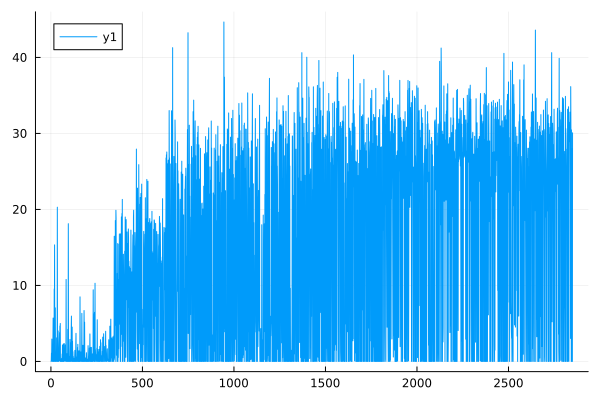

In [49]:
plot(opt.model.y)

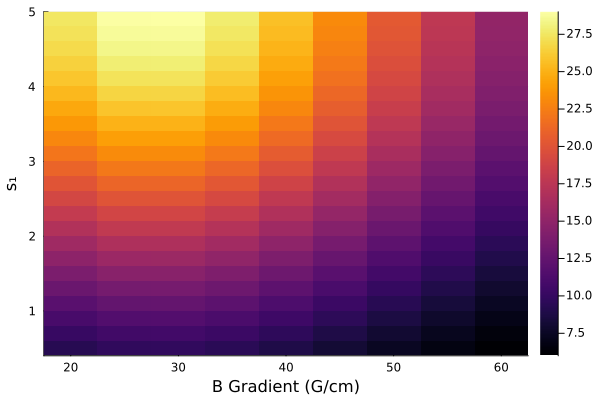

┌ Warning: G:\My Drive\github\UnitsToValue\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\Kw99o\src\packagedef.jl:574
┌ Warning: G:\My Drive\github\OpticalBlochEquations\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\Kw99o\src\packagedef.jl:574
┌ Warning: G:\My Drive\github\QuantumStates\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\Kw99o\src\packagedef.jl:574


In [50]:
idx1 = 1
idx2 = 6

lists = [0.5:0.2:5, 0.5:0.2:5, 0.5:0.2:3, 0.5:0.2:3.0, 5:2:40, 20:5:60]
list1 = lists[idx1]
list2 = lists[idx2]

preds_mat = zeros(length(list1), length(list2))
points = zeros(6, 1)

labels = Dict(1=>"s₁", 2=>"s₃",  3=>"Δ₁ (Γ)", 4=>"Δ₃ (Γ)", 5=>"ramp time (ms)", 6=>"B Gradient (G/cm)")

for (i, val1) ∈ enumerate(list1)
    for (j, val2) ∈ enumerate(list2)
        points[:,1] .= opt.model_optimizer
        points[idx1,1] = val1
        points[idx2,1] = val2
        preds_mat[i,j] = predict_y(opt.model, points)[1][1]
    end
end
heatmap(list2, list1, preds_mat, xlabel=labels[idx2], ylabel=labels[idx1])
# scatter!(opt.model.x[idx2,:], opt.model.x[idx1,:], legend=nothing)